# Lab: Cross validation

Details of the crime dataset are [here](https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime).

We are going to examine the data, fit and then cross-validate a regression model.

In [1]:
import pandas as pd
df = pd.read_csv('data/censusCrimeClean.csv')
df.head()

,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,...,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,ViolentCrimesPerPop
0,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,...,0.0,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.20
1,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,...,0.0,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.67
2,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,...,0.0,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.43
3,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,...,0.0,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.12
4,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,...,0.0,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.03


One hundred features. Too many for us to visualise at once.

Instead, we can pick out particular variables and carry out a linear regression. To make our work simple we will look at ViolentCrimesPerPop as our dependent variable and medIncome as our indpendent variable.

We may wonder if there is more violent crime in low income areas.

Let us create a new dataframe containing our regression variables. We do not have to do this I find it makes our work clearer.

In [2]:
df_reg = df[['communityname', 'medIncome', 'ViolentCrimesPerPop']]
df_reg

,communityname,medIncome,ViolentCrimesPerPop
0,Lakewoodcity,0.37,0.20
1,Tukwilacity,0.31,0.67
2,Aberdeentown,0.30,0.43
3,Willingborotownship,0.58,0.12
4,Bethlehemtownship,0.50,0.03
...,...,...,...
1989,TempleTerracecity,0.42,0.09
1990,Seasidecity,0.28,0.45
1991,Waterburytown,0.31,0.23
1992,Walthamcity,0.44,0.19


Plot our data (a nice page on plotting regressions with seaborn is [here](http://seaborn.pydata.org/tutorial/regression.html#:~:text=Two%20main%20functions%20in%20seaborn%20are%20used%20to,quickly%20choose%20the%20correct%20tool%20for%20particular%20job.)).

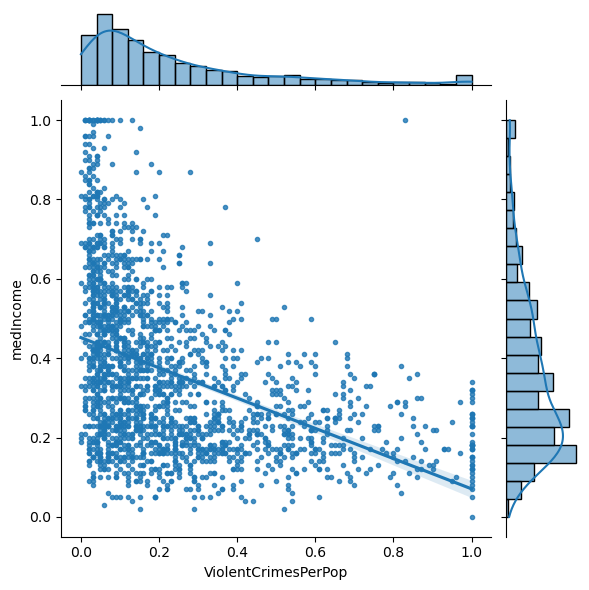

In [3]:
import seaborn as sns
sns.jointplot(data = df[['medIncome', 'ViolentCrimesPerPop']], 
              x = 'ViolentCrimesPerPop', 
              y = 'medIncome', kind='reg',
              marker = '.')

We may want to z-transform or log these scores as they are heavily skewed.

In [4]:
import numpy as np

# some values are 0 so 0.1 is added to prevent log giving us infinity
# there may be a better way to do this!
df_reg.loc[:, 'ViolentCrimesPerPop_log'] = np.log(df_reg['ViolentCrimesPerPop'] + 0.1)
df_reg.loc[:,'medIncome_log'] = np.log(df_reg['medIncome'] + 0.1)

TypeError: unhashable type: 'slice'

In [ ]:
df_reg

In [ ]:
import seaborn as sns
sns.jointplot(data = df_reg[['medIncome_log', 'ViolentCrimesPerPop_log']], 
              x = 'ViolentCrimesPerPop_log', 
              y = 'medIncome_log', kind='reg',
              marker = '.')

Is log transforming our variables the right thing to do here?

Fit our regression to the log transformed data.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import metrics

x = df_reg[['ViolentCrimesPerPop_log']]
y = df_reg[['medIncome_log']]

model = LinearRegression()
model.fit(x, y)

y_hat = model.predict(x)
plt.plot(x, y,'o', alpha = 0.5)
plt.plot(x, y_hat, 'r', alpha = 0.5)

plt.xlabel('Violent Crimes Per Population')
plt.ylabel('Median Income')

print ("MSE:", metrics.mean_squared_error(y_hat, y))
print ("R^2:", metrics.r2_score(y, y_hat))
print ("var:", y.var())

Has our log transformation distorted the pattern in the data?

In [ ]:
x = df_reg[['ViolentCrimesPerPop']]
y = df_reg[['medIncome']]

model = LinearRegression()
model.fit(x, y)

y_hat = model.predict(x)
plt.plot(x, y,'o', alpha = 0.5)
plt.plot(x, y_hat, 'r', alpha = 0.5)

plt.xlabel('Violent Crimes Per Population')
plt.ylabel('Median Income')

print ("MSE:", metrics.mean_squared_error(y_hat, y))
print ("R^2:", metrics.r2_score(y, y_hat))
print ("var:", y.var())

What is the relationship between violent crime and median income? Why might this be?

Assuming the log data is fine, have we overfit the model? Remember that a good model (which accurately models the relationship between violent crimes per population) need to be robust when faced with new data.

Kfold cross validation splits data into train and test subsets. We can then fit the regression to the training set and see how well it does for the test set. 

In [ ]:
from sklearn.model_selection import KFold

X = df_reg[['ViolentCrimesPerPop']]
y = df_reg[['medIncome']]

# get four splits, Each split contains a 
# test series and a train series.
kf = KFold(n_splits=4)

In [ ]:
# lists to store our statistics
r_vals = []
MSEs = []
medIncome_coef = []

for train_index, test_index in kf.split(X):
    # fit our model and extract statistics
    model = LinearRegression()
    model.fit(X.iloc[train_index], y.iloc[train_index])
    y_hat = model.predict(X.iloc[test_index])
    
    MSEs.append(metrics.mean_squared_error(y.iloc[test_index], y_hat))
    medIncome_coef.append(model.coef_[0][0])
    r_vals.append(metrics.r2_score(y.iloc[test_index], y_hat))

In [ ]:
data = {'MSE' : MSEs, 'medIncome coefficient' : medIncome_coef, 'r squared' : r_vals}
pd.DataFrame(data)

Does our model produce similiar coefficients with subsets of the data?

We can do this using an inbuild sklearn function (see [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)).

In [ ]:
from sklearn.model_selection import cross_val_score
x = df_reg[['ViolentCrimesPerPop']]
y = df_reg[['medIncome']]

model = LinearRegression()
model.fit(x, y)

print(cross_val_score(model, x, y, cv=4))

What do these values tell us about our model and data?

You might want to carry out [multiple regression](https://heartbeat.fritz.ai/implementing-multiple-linear-regression-using-sklearn-43b3d3f2fe8b) with more than one predictor variable, or reduce the number of dimensions, or perhaps address different questions using a clustering algorithm instead with all or a subset of features.